In [1]:
# Importando os pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import functions as f

from DataProcesser import DataProcesser

from sklearn.model_selection import train_test_split

In [2]:
# Importando o dataset de treinamento
treino = pd.read_csv('../datasets/treino.csv')

In [3]:
x_treino, x_teste, y_treino, y_teste = train_test_split(treino.drop(['id', 'classe'], axis=1), treino.classe, test_size=0.25, random_state=42)

In [4]:
dp_train = DataProcesser(X=x_treino, y=y_treino)
mean_dict = dp_train.get_means_by_column()

In [5]:
dp_teste = DataProcesser(X=x_teste, mean_dict=mean_dict)

In [6]:
x_train = dp_train.process_train_data()
x_test = dp_teste.process_test_data()

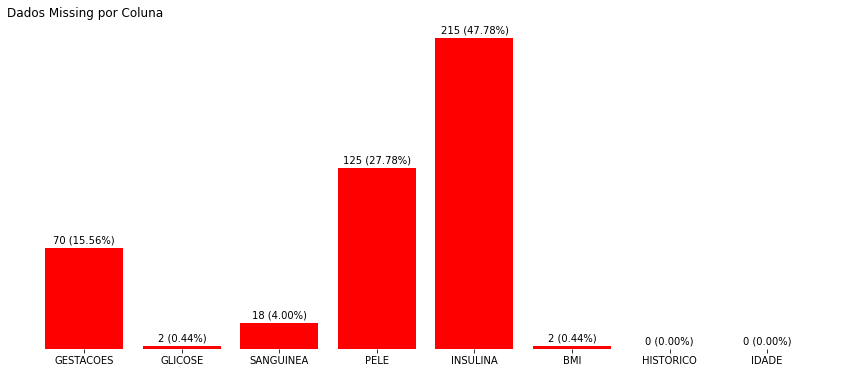

In [7]:
f.display_missing_barchart(dataframe=x_treino, columns=x_treino.columns, missing_value=0)

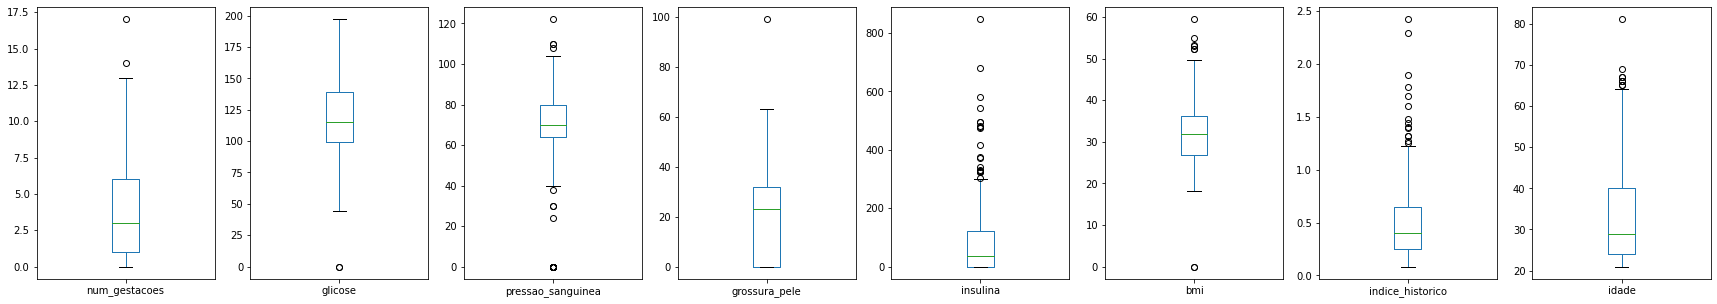

In [8]:
f.display_distribution_boxchart(dataframe=x_treino, columns=x_treino.columns)

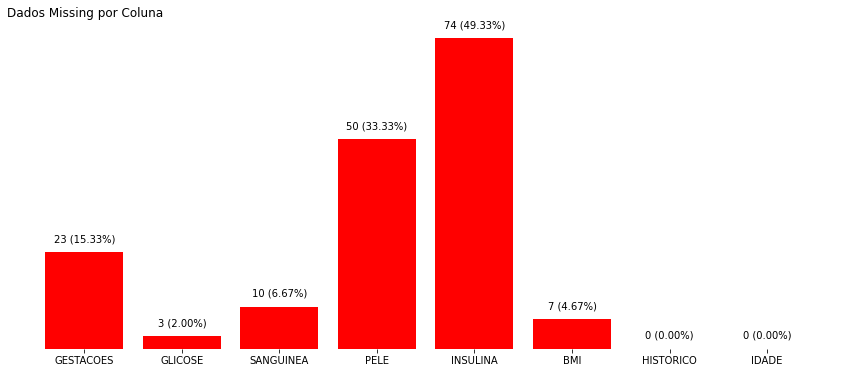

In [9]:
f.display_missing_barchart(dataframe=x_teste, columns=x_teste.columns, missing_value=0)

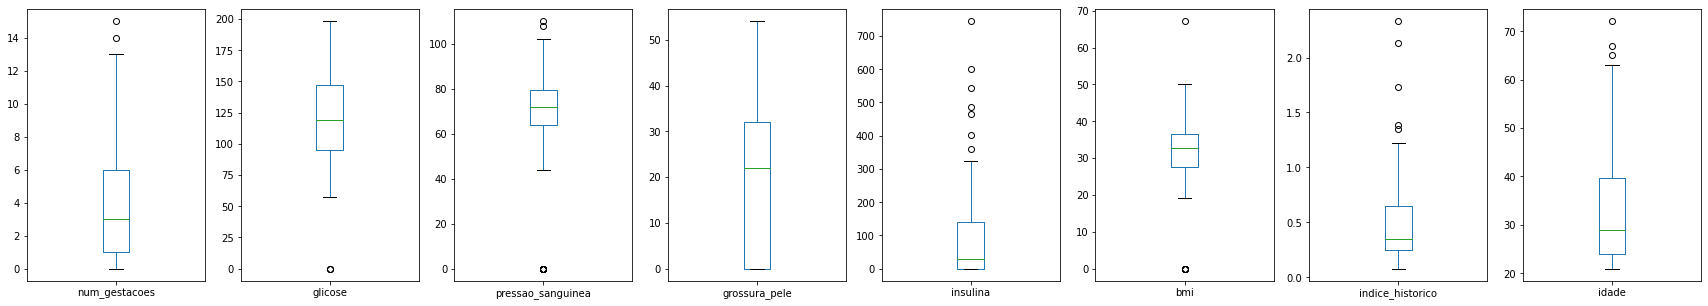

In [10]:
f.display_distribution_boxchart(dataframe=x_teste, columns=x_teste.columns)

In [7]:
# Verifica a coluna alvo para avaliar o balanceamento dos dados.
classes = treino.classe.value_counts()

print('DATASET TREINO:')
print('\nClasse 1 =', classes[1])
print('Classe 0 =', classes[0])
print('\nProporção =', '{:0.2f}%'.format(classes[1]*100/classes[0]), "\n")

DATASET TREINO:

Classe 1 = 208
Classe 0 = 392

Proporção = 53.06% 



In [8]:
# Definindo colunas onde os valores igual a 0 se referem a dados missing
miss = ['glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi']

print('Médias com valores missing:')
mean_class0 = treino.groupby('classe', as_index=False).mean().round()[miss]
print(mean_class0)

print(f'\nMedianas com valores missing:')
median_class0 = treino.groupby('classe', as_index=False).median()[miss]
print(median_class0)

Médias com valores missing:
   glicose  pressao_sanguinea  grossura_pele  insulina   bmi
0    109.0               68.0           20.0      67.0  30.0
1    140.0               70.0           22.0     103.0  35.0

Medianas com valores missing:
   glicose  pressao_sanguinea  grossura_pele  insulina   bmi
0    106.5               70.0           21.0      40.0  29.9
1    138.0               74.0           27.0       0.0  34.3


In [9]:
# Média desconsiderando os valores missing
means = []

for m in miss:
    treino0 = treino[treino[m] != 0]
    means.append(treino0.groupby('classe', as_index=False).mean().round()[m])

mean_class = pd.DataFrame(means)
print('MÉDIAS POR CLASSE:\n', mean_class)

MÉDIAS POR CLASSE:
                        0      1
glicose            110.0  142.0
pressao_sanguinea   70.0   75.0
grossura_pele       27.0   33.0
insulina           127.0  208.0
bmi                 31.0   36.0


In [10]:
# Mediana desconsiderando os valores missing
medians = []

for m in miss:
    treino0 = treino[treino[m] != 0]
    medians.append(treino0.groupby('classe', as_index=False).median()[m])

median_class = pd.DataFrame(medians)
print('MEDIANAS POR CLASSE:\n', median_class)

MEDIANAS POR CLASSE:
                         0      1
glicose            107.00  138.5
pressao_sanguinea   70.00   74.0
grossura_pele       27.00   32.0
insulina            94.00  175.0
bmi                 30.05   34.3


## Nesse caso, utilizaremos os dados referentes à mediana porque se trata de uma  estatística mais robusta quando temos que lidar com outliers no dataset.  

TypeError: 'module' object is not callable

DADOS MISSING POR COLUNA:
glicose = 5
pressao_sanguinea = 28
grossura_pele = 175
insulina = 289
bmi = 9


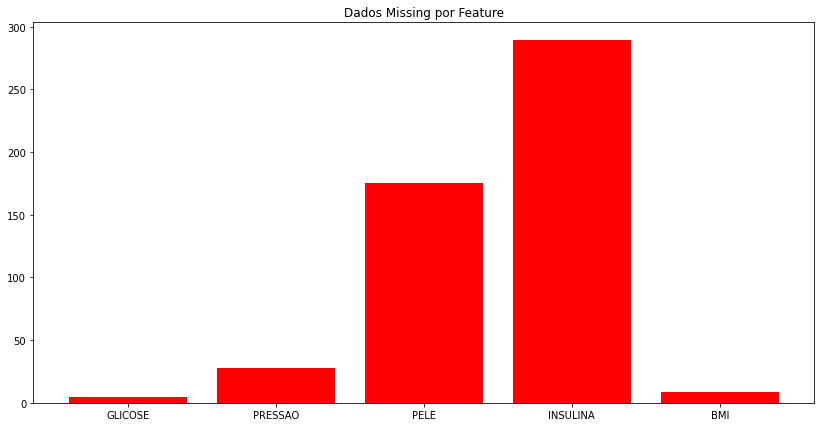

In [52]:
print('DADOS MISSING POR COLUNA:')

plt.figure(figsize=(14,7))

for m in miss:
    x = treino[m][treino[m] == 0].count()
    print(str(m), '=',  x)
    plt.bar(m, x, color='r') 

plt.xticks(range(5), ['GLICOSE', 'PRESSAO', 'PELE', 'INSULINA', 'BMI']) 
plt.title("Dados Missing por Feature")
plt.show()

In [53]:
# Avaliando a proporção de dados missing nas colunas com os maiores valores.

miss_insulina = treino.insulina[treino.insulina == 0].count()
miss_pele = treino.grossura_pele[treino.grossura_pele == 0].count()

print('Proporção de dados missing:\n')
print(f'Insulina = {miss_insulina*100/len(treino.insulina):0.2f}%')
print(f'Pele = {miss_pele*100/len(treino.grossura_pele):0.2f}%')

Proporção de dados missing:

Insulina = 48.17%
Pele = 29.17%


Temos uma quantidade considerável de valores missing em uma das variáveis mais importantes para a modelagem preditiva.
As formas de tratamento serão fundamentais para um bom resultado do modelo.

In [12]:
# Input das medianas substituindo valores missing, considerando as classes.
for m in miss:
    for i in range(len(treino[m])):
        for j in range(2):
            if treino[m][i] == 0 and treino['classe'][i] == j:
                treino[m][i] = median_class.loc[m][j]

In [13]:
# Verificando de os valores foram inputados corretamente.
treino.head()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
0,1,6,148,72,35,175,33.6,0.627,50,1
1,2,1,85,66,29,94,26.6,0.351,31,0
2,3,8,183,64,32,175,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [14]:
# Avaliando os dados estatisticos após substituição dos dados missing
treino.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,300.500000,3.820000,121.130000,72.035000,29.000000,138.980000,32.363167,0.481063,33.278333,0.346667
std,173.349358,3.362009,30.773822,11.987909,9.141258,92.952873,6.978906,0.337284,11.822315,0.476306
min,1.000000,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,150.750000,1.000000,99.000000,64.000000,25.000000,94.000000,27.400000,0.248000,24.000000,0.000000
50%,300.500000,3.000000,116.000000,72.000000,28.000000,94.000000,32.000000,0.384000,29.000000,0.000000
75%,450.250000,6.000000,140.000000,80.000000,32.000000,175.000000,36.525000,0.647000,40.000000,1.000000
max,600.000000,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


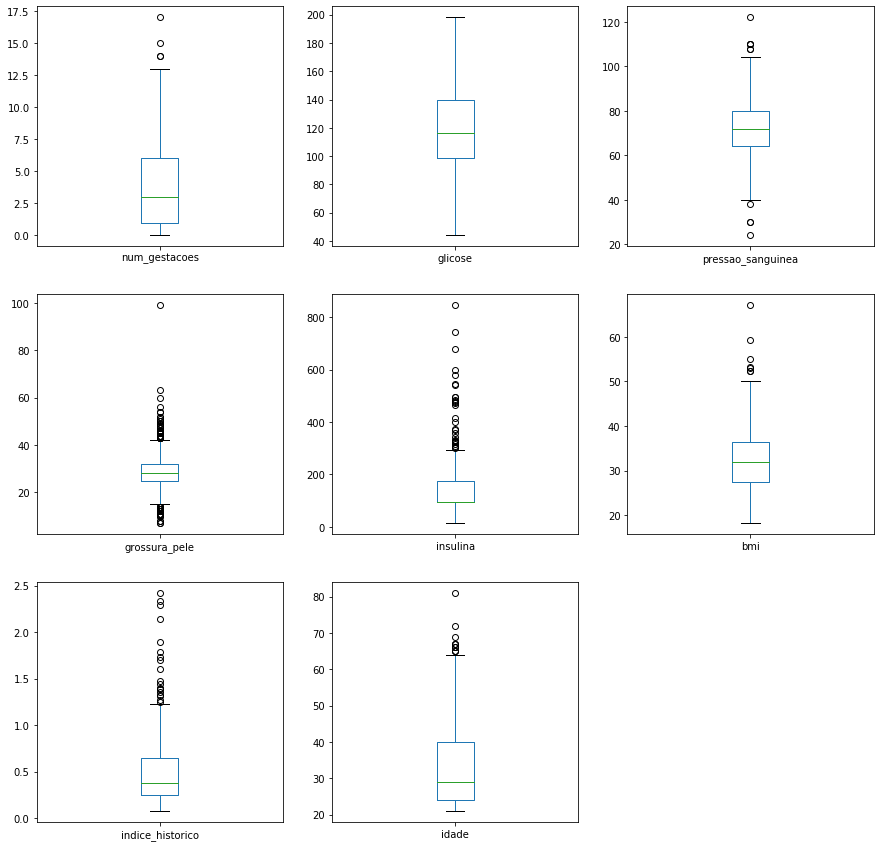

In [15]:
# Avaliando as distribuições de dados para cada variável via gráfico de caixa,
# onde conseguimos verificar a presença de outliers com maior facilidade.

# Na maioria dos gráficos temos a presença de outliers, destacando apenas um valor específico na coluna refente à pele.

treino.drop(['classe', 'id'], axis=1).plot(kind='box', subplots=True, layout=(3,3), figsize=(15,15))
plt.show()

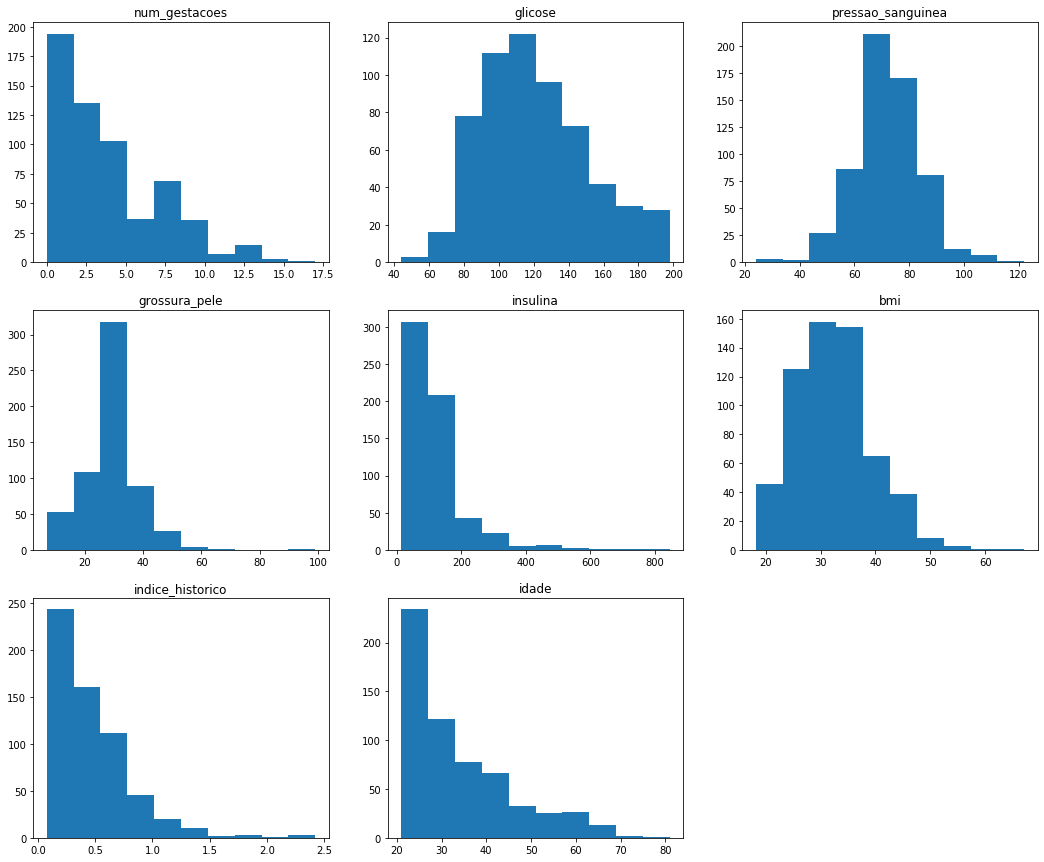

In [16]:
# Avaliando as distribuições de dados para cada variável via histograma,
# onde conseguimos verificar a forma dos dados com maior facilidade.

# Temos distribuições exponenciais e normais nos dados.

plt.figure(figsize=(18, 15))

for i, c in enumerate(treino.drop(['classe', 'id'], axis=1).columns):
    plt.subplot(331+i)
    plt.hist(treino[c])
    plt.title(f'{c}')
  
plt.show()

In [17]:
# Substituindo o outlier pelo valor da mediana na coluna referente a pele.
if treino.grossura_pele.max() > 63:
    treino.grossura_pele[treino.grossura_pele == treino.grossura_pele.max()] = treino.grossura_pele.median()

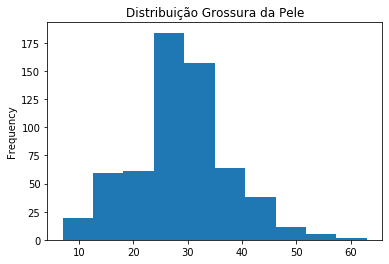

In [18]:
# Verificando a alteração na distribuição dos dados.
treino.grossura_pele.plot(kind='hist')
plt.title('Distribuição Grossura da Pele')
plt.show()

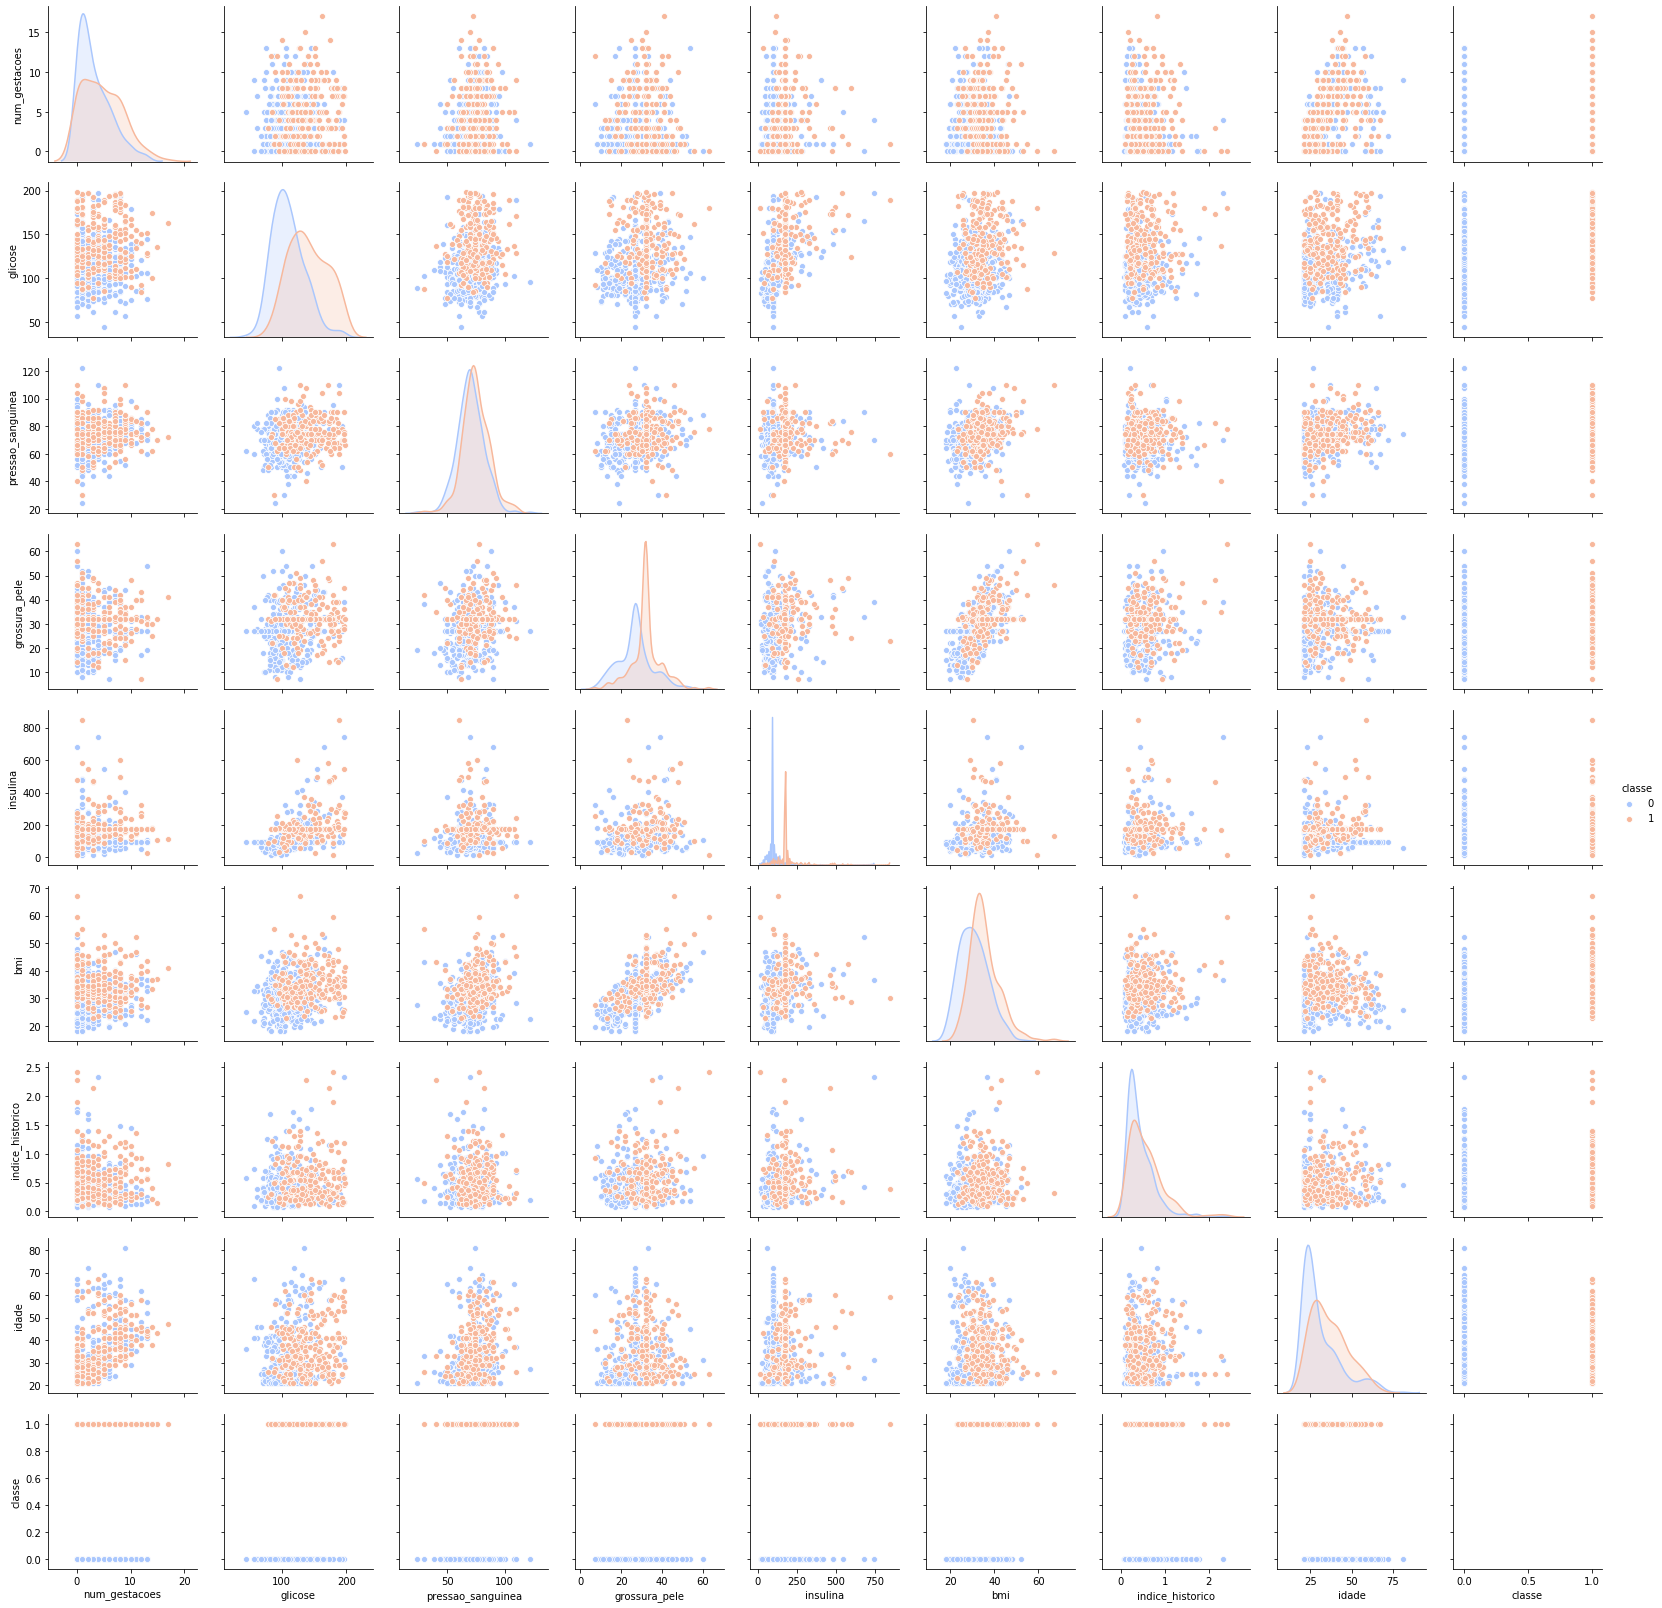

In [19]:
# Gerando gráfico para avaliar a correlação entre as variáveis
import seaborn as sns
sns.pairplot(treino.drop('id', axis=1),hue='classe',palette='coolwarm')

In [21]:
# Aplicando técnica de balanceamento das classes no dataset de treino
from imblearn.over_sampling import SMOTE
features = treino.drop(['id', 'classe'], axis=1).columns
x, y = SMOTE(random_state=1).fit_sample(treino[features], treino['classe'])

Using TensorFlow backend.


In [23]:
# Criando novo dataset balanceado
treino2 = pd.DataFrame(x)
treino2.columns = treino[features].columns
treino2['classe'] = y

# Verificando as estatisticas do dataset balanceado
treino2.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000
mean,4.056300,125.648329,72.854386,29.616635,151.618289,32.894411,0.499302,34.252409,0.500000
std,3.309210,31.278776,11.611322,8.357760,93.241710,6.677422,0.329816,11.568521,0.500319
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,102.680598,66.000000,26.000000,94.000000,28.619529,0.258000,25.000000,0.000000
50%,3.203247,122.000000,72.000000,30.000000,140.024999,32.674226,0.403045,31.000000,0.500000
75%,6.071581,146.000000,80.000000,33.000000,175.000000,36.500000,0.677250,41.000000,1.000000
max,17.000000,198.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [27]:
# Verifica a coluna alvo para avaliar o balanceamento dos dados.
classes = treino2.classe.value_counts()

print('DATASET TREINO:')
print('\nClasse 1 =', classes[1])
print('Classe 0 =', classes[0])
print('\nProporção =', '{:0.0f}%'.format(classes[1]*100/classes[0]), "\n")

DATASET TREINO:

Classe 1 = 392
Classe 0 = 392

Proporção = 100% 



In [28]:
# Padronizando os dados
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = treino2[features].columns
treino2[cols] = scaler.fit_transform(treino2[cols])
treino2['classe'] = [int(i) for i in treino2['classe']]
treino2.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,7.840000e+02,7.840000e+02,7.840000e+02,7.840000e+02,7.840000e+02,7.840000e+02,7.840000e+02,7.840000e+02,784.000000
mean,5.062560e-16,-5.225412e-17,-6.484219e-15,-3.452100e-15,1.189525e-17,4.502369e-15,-8.115674e-16,2.325379e-15,0.500000
std,1.000638e+00,1.000638e+00,1.000638e+00,1.000638e+00,1.000638e+00,1.000638e+00,1.000638e+00,1.000638e+00,0.500319
min,-1.226543e+00,-2.612009e+00,-4.210164e+00,-2.707792e+00,-1.476873e+00,-2.202016e+00,-1.278200e+00,-1.146289e+00,0.000000
25%,-9.241635e-01,-7.347600e-01,-5.906960e-01,-4.330040e-01,-6.183399e-01,-6.406083e-01,-7.320929e-01,-8.003025e-01,0.000000
50%,-2.579459e-01,-1.167136e-01,-7.362915e-02,4.589860e-02,-1.244152e-01,-3.299563e-02,-2.920354e-01,-2.813225e-01,0.500000
75%,6.093805e-01,6.510697e-01,6.157934e-01,4.050756e-01,2.509246e-01,5.403119e-01,5.398817e-01,5.836440e-01,1.000000
max,3.913914e+00,2.314600e+00,4.235262e+00,3.996845e+00,7.451869e+00,5.125844e+00,5.827261e+00,4.043510e+00,1.000000


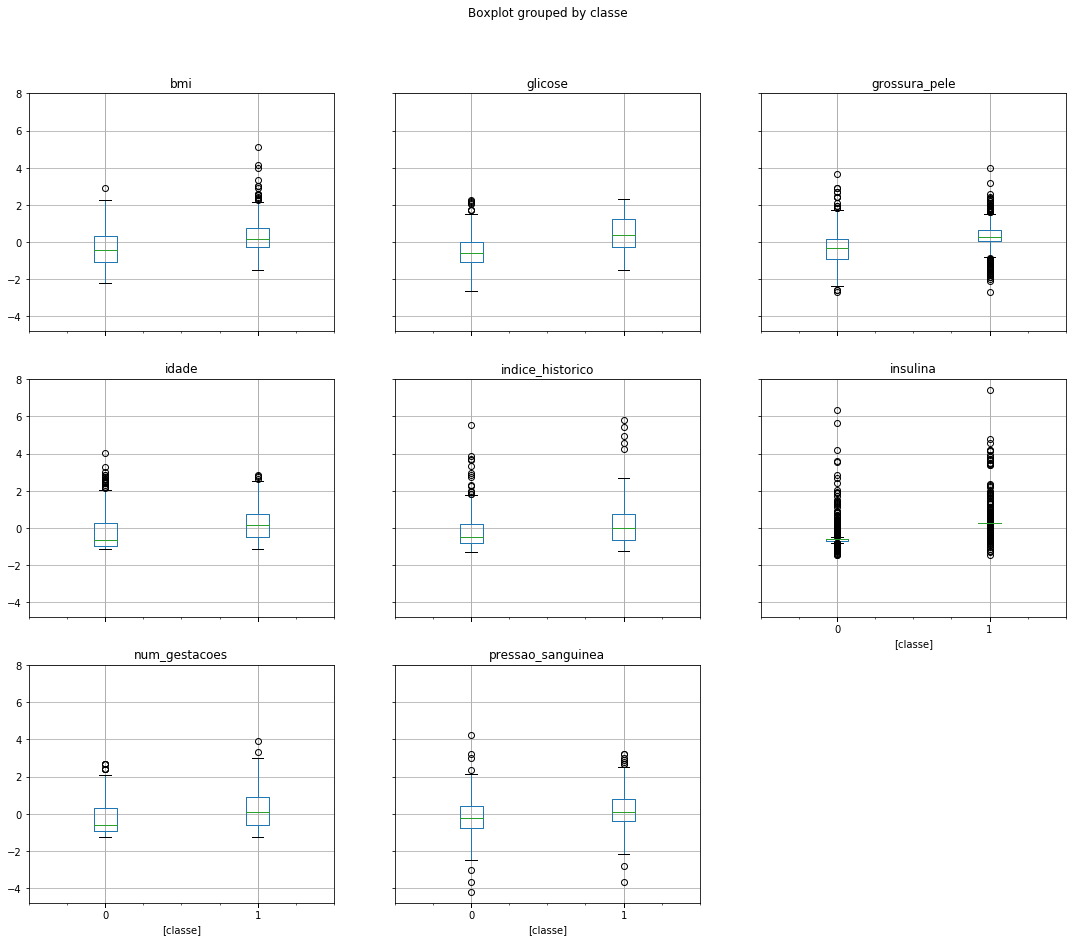

In [29]:
# Avaliando a distribuição dos dados por classe para verificar se existe algum padrão claro entre features e target.
treino2.boxplot(by='classe', layout=(3,3), figsize=(18,15))
plt.show()

In [30]:
treino2.to_csv('./dataset_treino_smt.csv', index=False)

# AVALIANDO DADOS DE TESTE

In [39]:
teste = pd.read_csv('dataset_teste.csv')
treino = pd.read_csv('dataset_treino.csv')

In [32]:
teste.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,84.500000,3.964286,124.148810,70.619048,20.827381,104.565476,32.304167,0.438583,33.125000
std,48.641546,3.441370,30.106525,19.321673,15.577120,353.528165,7.433299,0.308102,11.565584
min,1.000000,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,42.750000,1.000000,102.000000,62.000000,0.000000,0.000000,27.675000,0.222750,23.750000
50%,84.500000,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.341500,28.000000
75%,126.250000,6.000000,142.500000,80.500000,32.250000,136.250000,36.650000,0.588000,42.000000
max,168.000000,13.000000,212.000000,114.000000,49.000000,4444.000000,57.300000,1.698000,70.000000


glicose = 0
pressao_sanguinea = 7
grossura_pele = 49
insulina = 85
bmi = 2


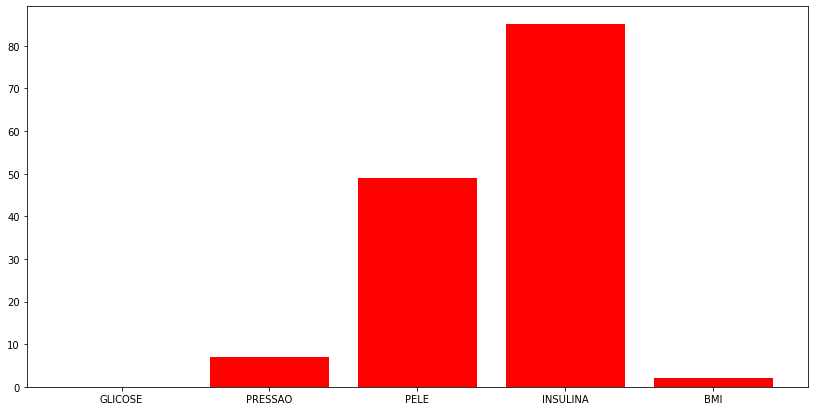

In [33]:
plt.figure(figsize=(14,7))

for m in miss:
    x = teste[m][teste[m] == 0].count()
    print(str(m), '=',  x)
    plt.bar(m, x, color='red')
    
plt.xticks(range(5), ['GLICOSE', 'PRESSAO', 'PELE', 'INSULINA', 'BMI'])  
plt.show()

In [35]:
# Gerando os dados para substituir os valores missing no dataset de teste pelas medianas independente da classe,
# utilizando as informações do dataset de treino.

medians_t = []

for m in miss:
    treino0 = treino[treino[m] != 0]
    medians_t.append(treino0[m].median())
    

median = pd.DataFrame({'Medianas': medians_t}, index=miss)
median

,Medianas
glicose,116.0
pressao_sanguinea,72.0
grossura_pele,29.0
insulina,120.0
bmi,32.0


In [40]:
# Substituindo valores missing
for m in miss:
    for i in range(len(teste[m])):
        if teste[m][i] == 0:
            teste[m][i] = median.loc[m][0]  

# Removendo outliers do dataset de teste.
# Substituimos pelos valores máximos e mínimos presentes no dataset de treino.
for m in miss:
    for i in range(len(teste[m])):
        if teste[m][i] > treino[m].max():
            teste[m][i] = treino[m].max()
        if teste[m][i] < treino[m].min():
            teste[m][i] = treino[m].min()          

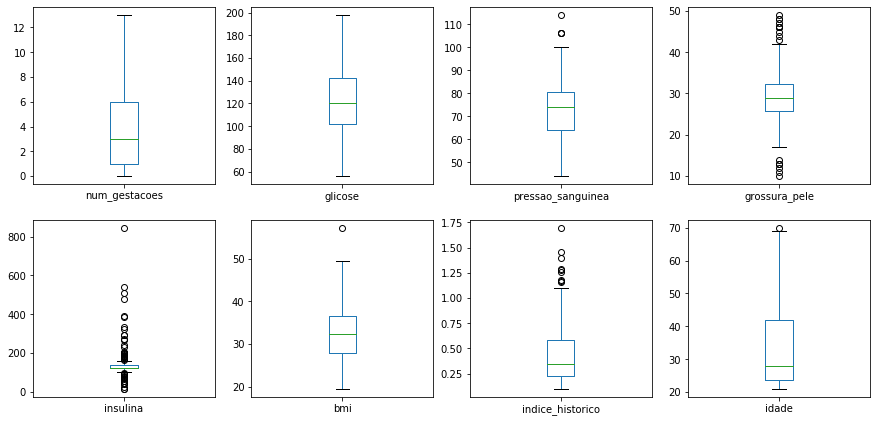

In [41]:
# Avaliando distribuição dos dados após alterações.
teste.drop('id', axis=1).plot(kind='box', subplots=True, layout=(4,4), figsize=(15,15))
plt.show()

In [42]:
# Verificando dados estatitiscos
teste.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,84.500000,3.964286,124.059524,73.619048,29.285714,143.863095,32.685119,0.438583,33.125000
std,48.641546,3.441370,29.865507,12.462547,7.936984,92.292034,6.527736,0.308102,11.565584
min,1.000000,0.000000,56.000000,44.000000,10.000000,15.000000,19.500000,0.100000,21.000000
25%,42.750000,1.000000,102.000000,64.000000,25.750000,120.000000,27.950000,0.222750,23.750000
50%,84.500000,3.000000,120.000000,74.000000,29.000000,120.000000,32.400000,0.341500,28.000000
75%,126.250000,6.000000,142.500000,80.500000,32.250000,136.250000,36.650000,0.588000,42.000000
max,168.000000,13.000000,198.000000,114.000000,49.000000,846.000000,57.300000,1.698000,70.000000


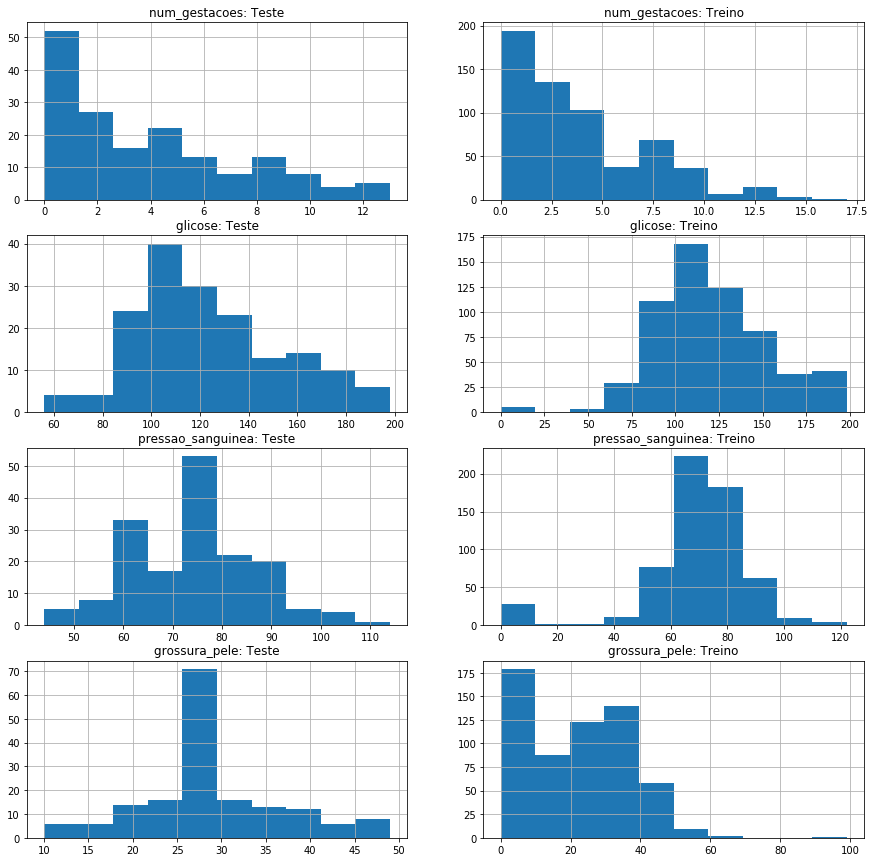

In [97]:
# Comparando a distribuição entre dados treino e teste - PARTE 1
colunas = teste.drop('id', axis=1).columns

plt.figure(figsize=(15,15))

i = 0
for c in colunas[:4]:
    plt.subplot(421+i)
    teste[c].hist()
    plt.title(f"{c}: Teste")
    plt.subplot(422+i)
    treino[c].hist()
    plt.title(f"{c}: Treino")
    i += 2
   
plt.show()

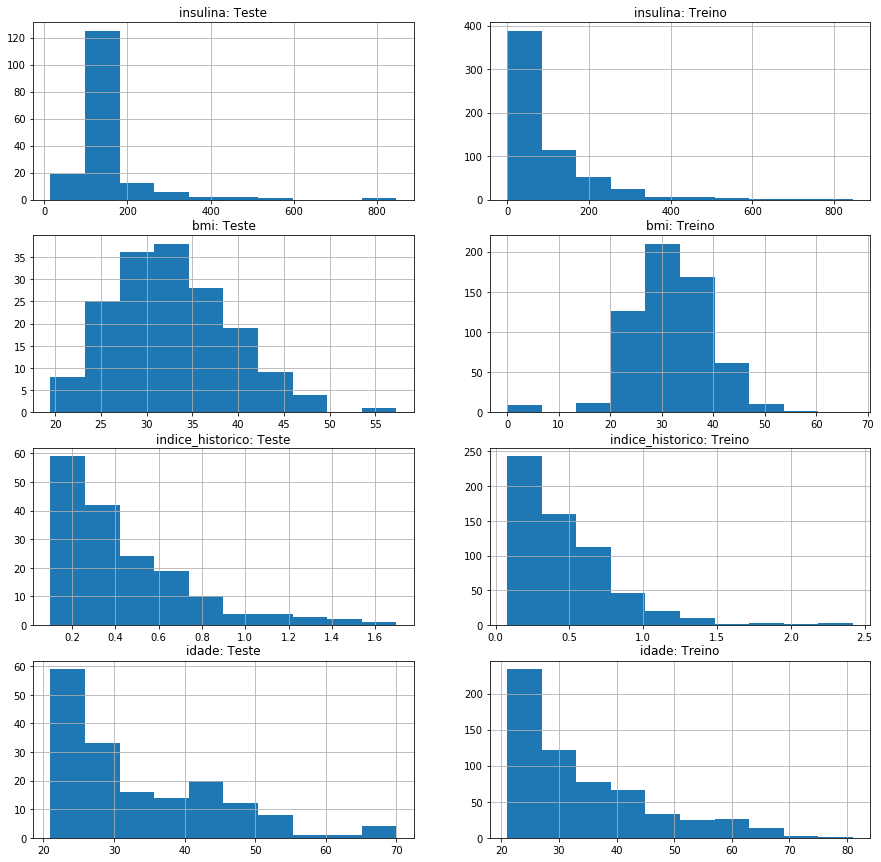

In [98]:
# Comparando a distribuição entre dados treino e teste - PARTE 2
colunas = teste.drop('id', axis=1).columns

plt.figure(figsize=(15,15))

i = 0
for c in colunas[4:]:
    plt.subplot(421+i)
    teste[c].hist()
    plt.title(f"{c}: Teste")
    plt.subplot(422+i)
    treino[c].hist()
    plt.title(f"{c}: Treino")
    i += 2
   
plt.show()

In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = teste[features].columns
teste[cols] = scaler.fit_transform(teste[cols])
teste['id'] = [int(i) for i in teste['id']]
teste.head()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
0,1,-0.863943,-0.539336,1.157383,-1.299796,-0.259334,-0.858156,-0.125604,-0.791337
1,2,0.593310,-0.942338,-0.130301,-0.036105,-0.259334,-1.380568,-0.809234,-0.444450
2,3,-0.863943,-0.001999,0.030659,0.848478,-0.259334,-0.750601,-1.102218,-0.271006
3,4,0.884761,0.871173,0.352580,-0.036105,-0.194128,0.386413,0.824968,1.810320
4,5,0.010409,1.979430,-0.130301,-0.036105,-0.259334,-0.658410,-0.737615,0.249326


In [100]:
teste.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
count,168.000000,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02
mean,84.500000,-6.476301e-17,-5.286776e-17,-1.232480e-16,9.846621e-17,-7.269317e-18,1.027617e-16,3.304235e-17,2.907727e-17
std,48.641546,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00
min,1.000000,-1.155394e+00,-2.285680e+00,-2.383750e+00,-2.437118e+00,-1.400428e+00,-2.025899e+00,-1.102218e+00,-1.051503e+00
25%,42.750000,-8.639430e-01,-7.408370e-01,-7.741438e-01,-4.468050e-01,-2.593337e-01,-7.275532e-01,-7.026201e-01,-8.130179e-01
50%,84.500000,-2.810417e-01,-1.363332e-01,3.065916e-02,-3.610546e-02,-2.593337e-01,-4.380867e-02,-3.160434e-01,-4.444498e-01
75%,126.250000,5.933102e-01,6.192965e-01,5.537811e-01,3.745941e-01,-8.273580e-02,6.092057e-01,4.864084e-01,7.696570e-01
max,168.000000,2.633465e+00,2.483183e+00,3.249871e+00,2.491276e+00,7.630517e+00,3.782088e+00,4.099883e+00,3.197871e+00


In [101]:
teste.to_csv('./dataset_teste_ajustado.csv', index=False)